In [ ]:
import sys
!{sys.executable} -m pip install squarify

In [ ]:
#states under consideration: Illinois, Florida, Oregon, New Hampshire, Colorado, California, New Jersey, Arizona

In [ ]:
import scipy.stats
import matplotlib.pyplot as plt
import copy
from sklearn import linear_model

import matplotlib
from scipy import stats
from scipy.optimize import curve_fit
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets
import seaborn as sns
import json
import statsmodels.api as sm
import squarify

import pandas as pd
import numpy as np
import folium
from folium.features import DivIcon
import requests
from bs4 import BeautifulSoup
import re

%matplotlib inline

In [ ]:
#existing data
floridaFrame = pd.read_csv('FloridaResults.csv')
floridaCounties = ["Alachua","Baker","Bay","Bradford","Brevard","Broward","Calhoun","Charlotte","Citrus","Clay","Collier","Columbia","DeSoto","Dixie","Duval","Escambia","Flagler","Franklin","Gadsden","Gilchrist","Glades","Gulf","Hamilton","Hardee","Hendry","Hernando","Highlands","Hillsborough","Holmes","Indian River","Jackson","Jefferson","Lafayette","Lake","Lee","Leon","Levy","Liberty","Madison","Manatee","Marion","Martin","Miami-Dade","Monroe","Nassau","Okaloosa","Okeechobee","Orange","Osceola","Palm Beach","Pasco","Pinellas","Polk","Putnam","Santa Rosa","Sarasota","Seminole","St. Johns","St. Lucie","Sumter","Suwannee","Taylor","Union","Volusia","Wakulla","Walton","Washington"]

In [ ]:
#lets compute centroids of counties

In [ ]:
def centeroidnp(arr):
    length = arr.shape[0]
    sum_x = np.sum(arr[:, 0])
    sum_y = np.sum(arr[:, 1])
    return sum_x/length, sum_y/length

In [ ]:
counties = pd.read_json('us-counties.json')
floridacounties = []
floridaPoints = []
for i in range(len(counties['features'])):
    county = counties.iloc[i]['features']
    name = county["properties"]["name"]
    name = name.strip()
    if(county["id"][0:2] == "12"):
         floridacounties.append(county)
         floridaPoints.append(county["geometry"]["coordinates"][0])
jsonDict = {"type": "FeatureCollection", "features": floridacounties}
with open('fl-counties.json', 'w') as outfile:  
    json.dump(jsonDict, outfile)

In [ ]:
def plotSums(df):
    demCountiesSums = []
    repCountiesSums = []
    years = list(range(1976, 2044, 4))
    for year in years:
        demList = []
        repList = []
        for county in df['Partisan Lean ' + str(year)]:
          if (county > 0):
             demList.append(county)
          else:
             repList.append(county) 
        
        demCountiesSums.append(len(demList))
        repCountiesSums.append(len(repList))
    sumDataframe = pd.DataFrame({'year': years, 'demList': demCountiesSums, 'repList': repCountiesSums})
    f, ax = plt.subplots(1, 1)
    sns.pointplot(x="year", y="demList", data=sumDataframe, color='blue')
    sns.pointplot(x="year", y="repList", data=sumDataframe, color='red')
    ax.set_title("Counties by Party")
    ax.set_xlabel("Year")
    ax.set_ylabel("Number of counties")
    ax.set_yticks(list(range(0, 70, 5)))
    ax.legend(["Democratic", "Republican"])

In [ ]:
def plotLeans(df):
    demAverageLean = []
    repAverageLean = []
    years = list(range(1976, 2044, 4))
    for year in years:
        demList = []
        repList = []
        for county in df['Partisan Lean ' + str(year)]:
            if (county > 0):
                demList.append(county)
            else:
                repList.append(county) 
        if (len(demList) != 0):
            demAverageLean.append((sum(demList)*1.0)/len(demList))
        else:
            demAverageLean.append(0.0)
        if (len(repList) != 0):
            repAverageLean.append((sum(repList)*1.0)/len(repList))
        else:
            repAverageLean.append(0.0)
    leanDF = pd.DataFrame({'year': years, 'demList': demAverageLean, 'repList': repAverageLean})
    f, ax = plt.subplots(1, 1)
    sns.pointplot(x="year", y="demList", data=leanDF, color='blue')
    sns.pointplot(x="year", y="repList", data=leanDF, color='red')
    ax.set_xlabel("Year")
    ax.set_ylabel("Partisan Lean")

    yList = [-.4]
    s = -.40
    for a in range(20):
        s += .05
        yList.append(s)
    
    ax.set_yticks(yList)
    ax.legend(["Democratic", "Republican"])
    ax.set_xlabel("Year")
    ax.set_ylabel("Partisan Lean value")
    ax.set_title("Partisan Lean (1976-2040)")

In [ ]:
def func(x, a, b):
    return a*np.log(x) + b

In [ ]:
def extendedMap(df, year, loc, zoom, points):
    foliumMap = folium.Map(location=loc, zoom_start=zoom)
    yearCol = "Partisan Lean " + str(year)
    legendCol = "Partisan Lean " + str(year)
    foliumMap.choropleth(geo_data=geo, data=df,
             columns=['counties', yearCol],
             key_on='feature.properties.name', threshold_scale=[-.10, -.05, 0, .05, .10],
             fill_color='RdBu', fill_opacity=0.7, line_opacity=0.2,
             legend_name=legendCol)
    a = 0
    for county in df['counties']:
        latitude = None
        longitude = None
        try:
           longitude, latitude = centeroidnp(np.array(points[a]))
           folium.features.Marker(location=[latitude, longitude], icon=DivIcon(icon_size=(10,8),icon_anchor=(0,0), html='<div style="font-size: 6pt">'+ county + '</div>')).add_to(foliumMap)
           a += 1
        except (IndexError):
            break
    return foliumMap

In [ ]:
geo = r'fl-counties.json'
slider = widgets.IntSlider(value=1976, min=1976, max=2040, step=4)
interact(extendedMap, df=fixed(floridaFrame), year=slider, loc=fixed((27.7, -81.5)), zoom=fixed(6), points=fixed(floridaPoints))
None

In [ ]:
def constructExtendedTreemap(df, year):
    cmap = matplotlib.cm.RdBu
    dfSorted = df.sort_values(str(year)+"Total", ascending=False)
    mini=min(df['Partisan Lean '+str(year)])
    maxi=max(df['Partisan Lean '+str(year)])
    norm = matplotlib.colors.Normalize(vmin=-1, vmax=1)
    colors = [cmap(norm(value)) for value in dfSorted['Partisan Lean '+str(year)]]
    
    plt.rc('font', size=22)
    squarify.plot(sizes=dfSorted[str(year)+"Total"], label=dfSorted['counties'], alpha=0.8, color=colors )
    plt.axis('off')
    fig = plt.gcf()
    fig.set_size_inches(20, 16)
    plt.show()

In [ ]:
geo = r'fl-counties.json'
slider = widgets.IntSlider(value=1976, min=1976, max=2040, step=4)
interact(constructExtendedTreemap, df=fixed(floridaFrame), year=slider)
None

In [ ]:
def constructBarplot(df, minYear, maxYear, title):
    demTotals = []
    repubTotals = []

    for year in range(minYear, maxYear, 4):
       dTotal = 0.0
       rTotal = 0.0
       if (year <= 2016):
          for i in range(len(df)):
              dTotal += df.get_value(i, str(year)+"D") * df.get_value(i, str(year)+"Total") 
              rTotal += df.get_value(i, str(year)+"R") * df.get_value(i, str(year)+"Total")
       else: #based on partisan lean and national vote being tied
          for i in range(len(df)):
              dPerc = .5 + df.get_value(i, "Partisan Lean " + str(year))
              rPerc = .5 - df.get_value(i, "Partisan Lean " + str(year)) 
              if (dPerc < 0):
                 dPerc = 0.0
              if (dPerc > 1):
                 dPerc = 1.0
              if (rPerc < 0):
                  rPerc = 0.0
              if (rPerc > 1):
                  rPerc = 1.0
                
              dTotal += df.get_value(i, str(year)+"Total") * dPerc
              rTotal += df.get_value(i, str(year)+"Total") * rPerc  
       
       print("Year: " + str(year) + "DemTotal: " + str(dTotal) + "RepTotal: " + str(rTotal))
       demTotals.append(dTotal/(dTotal+rTotal))
       repubTotals.append(rTotal/(dTotal+rTotal))
        
    ax = sns.barplot(x=list(range(minYear, maxYear, 4)), y=demTotals)
    fig = plt.gcf()

    demList = []
    s = 0.0
    for a in range(20):
        s += .05
        demList.append(s)
    
    ax.set_yticks(demList)
    fig.set_size_inches(50, 16)
    ax.set_title(title)
    ax.set_xlabel("Year")
    ax.set_ylabel("Percentage Lean")
    
#     ax = sns.barplot(x=list(range(minYear, maxYear, 4)), y=repubTotals)
#     fig = plt.gcf()

#     repubList = []
#     s = 0.0
#     for a in range(20):
#         s += .05
#         repubList.append(s)
    
#     ax.set_yticks(repubList)
#     fig.set_size_inches(20, 16)

In [ ]:
constructBarplot(floridaFrame, 1976, 2044, "Democratic Lean of Florida (1976-2040)")

In [ ]:
plotSums(floridaFrame)

In [ ]:
plotLeans(floridaFrame)

In [ ]:
oregonFrame = pd.read_csv("OregonResults.csv")
oregonCounties = ['Baker', 'Benton', 'Clackamas', 'Clatsop', 'Columbia', 'Coos', 'Crook', 'Curry', 'Deschutes', 'Douglas', 'Gilliam', 'Grant', 'Harney', 'Hood River', 'Jackson', 'Jefferson', 'Josephine', 'Klamath', 'Lake', 'Lane', 'Lincoln', 'Linn', 'Malheur', 'Marion', 'Morrow', 'Multnomah', 'Polk', 'Sherman', 'Tillamook', 'Umatilla', 'Union', 'Wallowa', 'Wasco', 'Washington', 'Wheeler', 'Yamhill']

In [ ]:
counties = pd.read_json('us-counties.json')
points = []
for i in range(len(counties['features'])):
    county = counties.iloc[i]['features']
    name = county["properties"]["name"]
    name = name.strip()
    if(county["id"][0:2] == "41"):
         points.append(county["geometry"]["coordinates"][0])

In [ ]:
geo = r'or-counties.json'
slider = widgets.IntSlider(value=1976, min=1976, max=2040, step=4)
interact(constructExtendedTreemap, df=fixed(oregonFrame), year=slider, points=fixed(points))
None

In [ ]:
slider = widgets.IntSlider(value=1976, min=1976, max=2040, step=4)
interact(extendedMap, df=fixed(oregonFrame), year=slider, loc=fixed((44, -121)),zoom=fixed(6), points=fixed(points))
None

In [ ]:
constructBarplot(oregonFrame, 1976, 2044, "Democratic Lean of Oregon (1976-2040)")

In [ ]:
plotSums(oregonFrame)

In [ ]:
plotLeans(oregonFrame)

In [ ]:
illinoisFrame = pd.read_csv('IllinoisResults.csv')
illinoisCounties = ["Adams","Alexander","Bond","Boone","Brown","Bureau","Calhoun","Carroll","Cass","Champaign","Christian","Clark","Clay","Clinton","Coles","Cook","Crawford","Cumberland","De Witt","DeKalb","Douglas","DuPage","Edgar","Edwards","Effingham","Fayette","Ford","Franklin","Fulton","Gallatin","Greene","Grundy","Hamilton","Hancock","Hardin","Henderson","Henry","Iroquois","Jackson","Jasper","Jefferson","Jersey","Jo Daviess","Johnson","Kane","Kankakee","Kendall","Knox","LaSalle","Lake","Lawrence","Lee","Livingston","Logan","Macon","Macoupin","Madison","Marion","Marshall","Mason","Massac","McDonough","McHenry","McLean","Menard","Mercer","Monroe","Montgomery","Morgan","Moultrie","Ogle","Peoria","Perry","Piatt","Pike","Pope","Pulaski","Putnam","Randolph","Richland","Rock Island","Saline","Sangamon","Schuyler","Scott","Shelby","St. Clair","Stark","Stephenson","Tazewell","Union","Vermilion","Wabash","Warren","Washington","Wayne","White","Whiteside","Will","Williamson","Winnebago","Woodford"]

In [ ]:
geo = r'il-counties.json'
slider = widgets.IntSlider(value=1976, min=1976, max=2040, step=4)
interact(constructExtendedTreemap, df=fixed(illinoisFrame), year=slider)
None

In [ ]:
counties = pd.read_json('us-counties.json')
points = []
for i in range(len(counties['features'])):
    county = counties.iloc[i]['features']
    name = county["properties"]["name"]
    name = name.strip()
    if(county["id"][0:2] == "17"):
         points.append(county["geometry"]["coordinates"][0])

In [ ]:
slider = widgets.IntSlider(value=1976, min=1976, max=2040, step=4)
interact(extendedMap, df=fixed(illinoisFrame), year=slider, loc=fixed((40, -90)),zoom=fixed(6), points=fixed(points))
None

In [ ]:
constructBarplot(illinoisFrame, 1976, 2044, "Democratic Lean of Illinois (1976-2040)")

In [ ]:
plotSums(illinoisFrame)

In [ ]:
plotLeans(illinoisFrame)

In [ ]:
californiaFrame = pd.read_csv("CaliforniaResults.csv")
californiaCounties = ['Alameda', 'Alpine', 'Amador', 'Butte', 'Calaveras', 'Colusa', 'Contra Costa', 'Del Norte', 'El Dorado', 'Fresno', 'Glenn', 'Humboldt', 'Imperial', 'Inyo', 'Kern', 'Kings', 'Lake', 'Lassen', 'Los Angeles', 'Madera', 'Marin', 'Mariposa', 'Mendocino', 'Merced', 'Modoc', 'Mono', 'Monterey', 'Napa', 'Nevada', 'Orange', 'Placer', 'Plumas', 'Riverside', 'Sacramento', 'San Benito', 'San Bernardino', 'San Diego', 'San Francisco', 'San Joaquin', 'San Luis Obispo', 'San Mateo', 'Santa Barbara', 'Santa Clara', 'Santa Cruz', 'Shasta', 'Sierra', 'Siskiyou', 'Solano', 'Sonoma', 'Stanislaus', 'Sutter', 'Tehama', 'Trinity', 'Tulare', 'Tuolumne', 'Ventura', 'Yolo', 'Yuba']

In [ ]:
counties = pd.read_json('us-counties.json')
points = []
for i in range(len(counties['features'])):
    county = counties.iloc[i]['features']
    name = county["properties"]["name"]
    name = name.strip()
    if(county["id"][0] == "6"):
         points.append(county["geometry"]["coordinates"][0])

In [ ]:
geo = r'ca-counties.json'
slider = widgets.IntSlider(value=1976, min=1976, max=2040, step=4)
interact(extendedMap, df=fixed(californiaFrame), year=slider, loc=fixed((37.8, -120)),zoom=fixed(5), points=fixed(points))
None

In [ ]:
geo = r'ca-counties.json'
slider = widgets.IntSlider(value=1976, min=1976, max=2040, step=4)
interact(constructExtendedTreemap, df=fixed(californiaFrame), year=slider)
None

In [ ]:
constructBarplot(californiaFrame, 1976, 2044, "Democratic Lean of California (1976-2040)")

In [ ]:
plotSums(californiaFrame)

In [ ]:
plotLeans(californiaFrame)

In [ ]:
newYorkFrame = pd.read_csv('newYorkResults.csv')
newYorkCounties = ["Albany","Allegany","Bronx","Broome","Cattaraugus","Cayuga","Chautauqua","Chemung","Chenango","Clinton","Columbia","Cortland","Delaware","Dutchess","Erie","Essex","Franklin","Fulton","Genesee","Greene","Hamilton","Herkimer","Jefferson","Kings","Lewis","Livingston","Madison","Monroe","Montgomery","Nassau","New York","Niagara","Oneida","Onondaga","Ontario","Orange","Orleans","Oswego","Otsego","Putnam","Queens","Rensselaer","Richmond","Rockland","Saratoga","Schenectady","Schoharie","Schuyler","Seneca","St. Lawrence","Steuben","Suffolk","Sullivan","Tioga","Tompkins","Ulster","Warren","Washington","Wayne","Westchester","Wyoming","Yates"]

In [ ]:
arizonaCounties = ["Apache", "Cochise", "Coconino", "Gila", "Graham", "Greenlee", "La Paz", "Maricopa", "Mohave", "Navajo", "Pima", "Pinal", "Santa Cruz", "Yavapai", "Yuma"]
arizonaFrame = pd.read_csv('arizonaResults.csv')

In [ ]:
counties = pd.read_json('us-counties.json')
points = []
for i in range(len(counties['features'])):
    county = counties.iloc[i]['features']
    name = county["properties"]["name"]
    name = name.strip()
    if(county["id"][0:2] == "36"):
        print(name)
        points.append(county["geometry"]["coordinates"][0])

In [ ]:
geo = r'ny-counties.json'
slider = widgets.IntSlider(value=1976, min=1976, max=2040, step=4)
interact(extendedMap, df=fixed(newYorkFrame), year=slider, loc=fixed((37.8, -120)),zoom=fixed(5), points=fixed(points))
None

In [ ]:
geo = r'ny-counties.json'
slider = widgets.IntSlider(value=1976, min=1976, max=2040, step=4)
interact(constructExtendedTreemap, df=fixed(newYorkprint(name)Frame), year=slider)
None

In [ ]:
constructBarplot(newYorkFrame, 1976, 2044, "Democratic Lean of New York (1976-2040)")

In [ ]:
plotSums(newYorkFrame)

In [ ]:
plotLeans(newYorkFrame)

In [73]:
counties = pd.read_json('us-counties.json')
points = []
for i in range(len(counties['features'])):
    county = counties.iloc[i]['features']
    name = county["properties"]["name"]
    name = name.strip()
    if(county["id"][0] == "4"):
        print(name)
        points.append(county["geometry"]["coordinates"][0])

Apache
Cochise
Coconino
Gila
Graham
Greenlee
La Paz
Maricopa
Mohave
Navajo
Pima
Pinal
Santa Cruz
Yavapai
Yuma
Adair
Alfalfa
Atoka
Beaver
Beckham
Blaine
Bryan
Caddo
Canadian
Carter
Cherokee
Choctaw
Cimarron
Cleveland
Coal
Comanche
Cotton
Craig
Creek
Custer
Delaware
Dewey
Ellis
Garfield
Garvin
Grady
Grant
Greer
Harmon
Harper
Haskell
Hughes
Jackson
Jefferson
Johnston
Kay
Kingfisher
Kiowa
Latimer
Le Flore
Lincoln
Logan
Love
McClain
McCurtain
McIntosh
Major
Marshall
Mayes
Murray
Muskogee
Noble
Nowata
Okfuskee
Oklahoma
Okmulgee
Osage
Ottawa
Pawnee
Payne
Pittsburg
Pontotoc
Pottawatomie
Pushmataha
Roger Mills
Rogers
Seminole
Sequoyah
Stephens
Texas
Tillman
Tulsa
Wagoner
Washington
Washita
Woods
Woodward
Baker
Benton
Clackamas
Clatsop
Columbia
Coos
Crook
Curry
Deschutes
Douglas
Gilliam
Grant
Harney
Hood River
Jackson
Jefferson
Josephine
Klamath
Lake
Lane
Lincoln
Linn
Malheur
Marion
Morrow
Multnomah
Polk
Sherman
Tillamook
Umatilla
Union
Wallowa
Wasco
Washington
Wheeler
Yamhill
Adams
Allegheny
Ar

In [74]:
geo = r'az-counties.json'
slider = widgets.IntSlider(value=1976, min=1976, max=2040, step=4)
interact(extendedMap, df=fixed(arizonaFrame), year=slider, loc=fixed((37.8, -120)),zoom=fixed(5), points=fixed(points))
None

In [75]:
geo = r'az-counties.json'
slider = widgets.IntSlider(value=1976, min=1976, max=2040, step=4)
interact(constructExtendedTreemap, df=fixed(arizonaFrame), year=slider)
None

Year: 1976DemTotal: 3412802.11299RepTotal: 3121574.88701
Year: 1980DemTotal: 3005848.47562RepTotal: 3195652.52438
Year: 1984DemTotal: 3130330.32872RepTotal: 3676454.67128
Year: 1988DemTotal: 3377379.07578RepTotal: 3108224.92422
Year: 1992DemTotal: 4062274.57372RepTotal: 2864520.42628
Year: 1996DemTotal: 4142731.97009RepTotal: 2173251.02991
Year: 2000DemTotal: 4305866.99873RepTotal: 2525165.00127
Year: 2004DemTotal: 4379493.61223RepTotal: 3012263.38777
Year: 2008DemTotal: 4854662.3173RepTotal: 2786164.6827
Year: 2012DemTotal: 4550471.29743RepTotal: 2530908.70257
Year: 2016DemTotal: 4754423.36328RepTotal: 2966651.63672
Year: 2020DemTotal: 4758836.5418RepTotal: 3038138.60106
Year: 2024DemTotal: 4819447.16586RepTotal: 3143676.53652
Year: 2028DemTotal: 4879449.33785RepTotal: 3249822.92406
Year: 2032DemTotal: 4938844.74861RepTotal: 3356576.07282
Year: 2036DemTotal: 4997635.08043RepTotal: 3463934.30052
Year: 2040DemTotal: 5055822.00707RepTotal: 3571895.9334


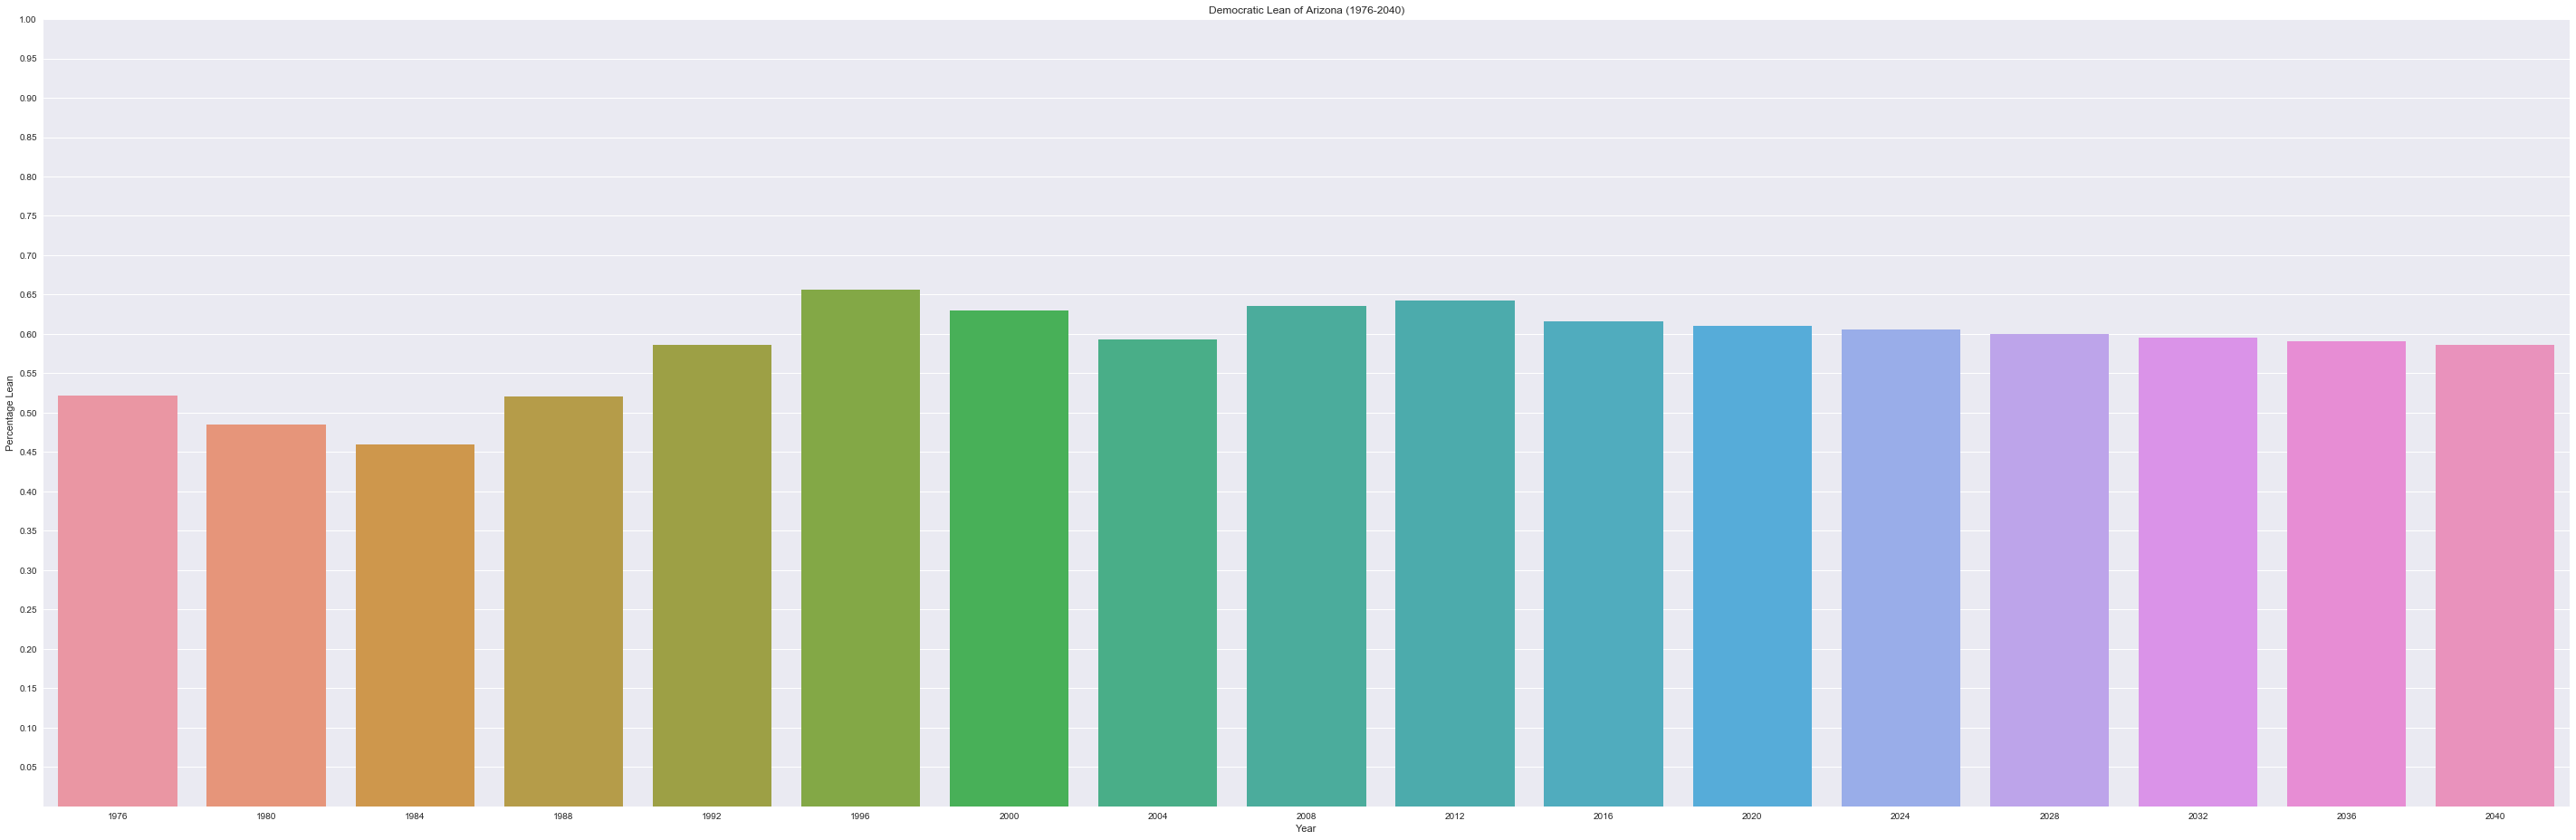

In [76]:
constructBarplot(newYorkFrame, 1976, 2044, "Democratic Lean of Arizona (1976-2040)")

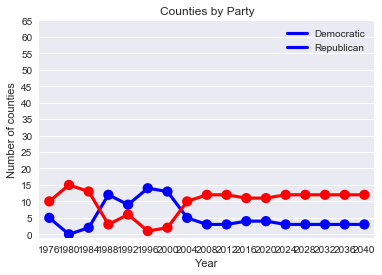

In [77]:
plotSums(arizonaFrame)

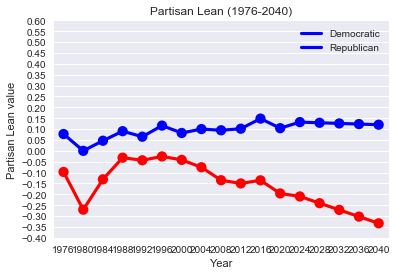

In [78]:
plotLeans(arizonaFrame)